## Meuse forcing timeseries
- Plotting each forcing parameter for each Meuse catchment
- Removign outliers from timeseries

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

import pickle

In [2]:
os.getcwd()

'E:\\thesis_data\\My_MTS-LSTM\\notebooks_latest'

In [3]:
# with open('data/basins_europe.txt', 'rb') as f:
#     basins = [line.decode().rstrip() for line in f]

# basins_rand = ['01195100', '04057510', '07208500', '09047700', '10343500']
# basins_rand = random.choices(basins, k=20)
basins = ['meuse_6', 'meuse_13', 'meuse_701', 'meuse_702', 'meuse_703']

In [4]:
name_dict = {'cp': 'convective_fraction',
             'msdwlwrf': 'longwave_radiation',
             'cape': 'potential_energy',
             'pev': 'potential_evaporation',
             'press': 'pressure',
             'kin': 'shortwave_radiation',
             'd2m': 'specific_humidity',
             'temp': 'temperature',
             'precip': 'total_precipitation',
             'u10': 'wind_u',
             'v10': 'wind_v',
             'qobs': 'qobs_mm_per_hour'
            }


In [5]:
q_meuse = xr.open_dataset('data/europe/Meuse/qobs_hourly_belgian_catch.nc')
areas = [551.65, 305.82, 162.81, 232.15, 123.91, 405.49]
q_meuse = q_meuse.rename({'time': 'date'})
q_meuse

<xarray.Dataset>
Dimensions:     (catchments: 19, date: 115200)
Coordinates:
  * catchments  (catchments) int32 5 6 503 501 801 802 ... 1003 10 11 12 13 1401
  * date        (date) datetime64[ns] 2005-01-01T01:00:00 ... 2018-02-22
Data variables:
    Qobs_m3s    (date, catchments) float64 ...

In [6]:
# combine datasets into one xarray dataset and convert Q from m3/s to mm/h
i = 0
for basin in basins:
    if basin.startswith('rhine'):
        continue
    if basin.endswith('501'):
        continue
        
    ds = xr.open_dataset('data/hydromt/ubasin_v5/rhine-meuse/pet_clean/mean/' + basin + '.nc')
    
    for var in list(ds.keys()):
        ds[var] = ds[var].sel({'basin':basin}).drop('basin')
        
    catchm = int(basin.split('_')[-1])
    ds['qobs_m3s'] = q_meuse.sel({'catchments': catchm})['Qobs_m3s']
    
    ds['qobs'] = ds['qobs_m3s'] / areas[i] * 1000 * 3600 / 1000000
    # m3/s /m2 * mm/m * s/h /(10**6mm2/m2)
    
    ds['qobs'] = ds.qobs.astype('float32')
    ds['qobs_m3s'] = ds.qobs_m3s.astype('float32')

    ds = ds.drop(['basin', 'spatial_ref', 'catchments'])
#     ds = ds.rename_vars(name_dict)
    print(basin, areas[i])
    i += 1
    
    ds.to_netcdf('data/europe/Meuse/' + basin + '.nc')
    ds.close()

meuse_6 551.65
meuse_13 305.82
meuse_701 162.81
meuse_702 232.15
meuse_703 123.91


### Plotting all timeseries for each forcing parameter of all 5 test catchments
#### Potential Energy:

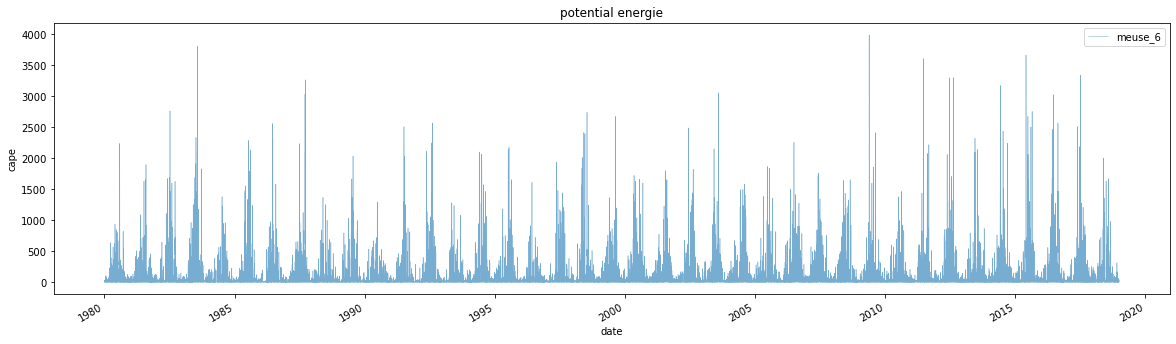

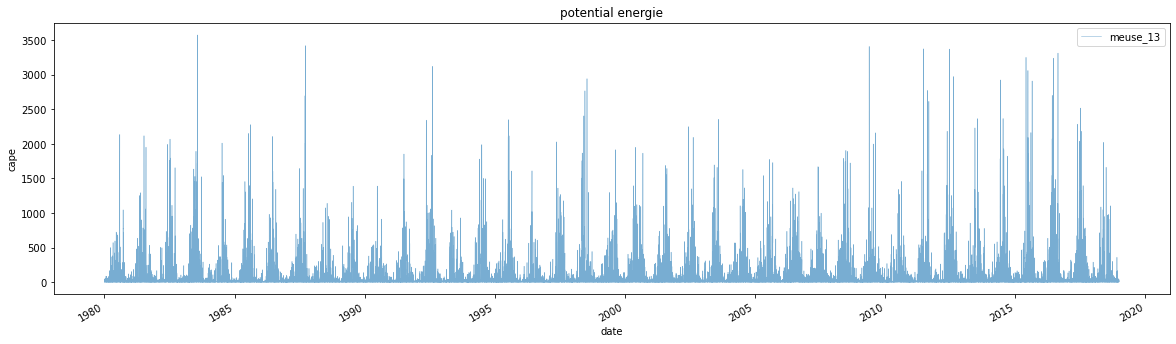

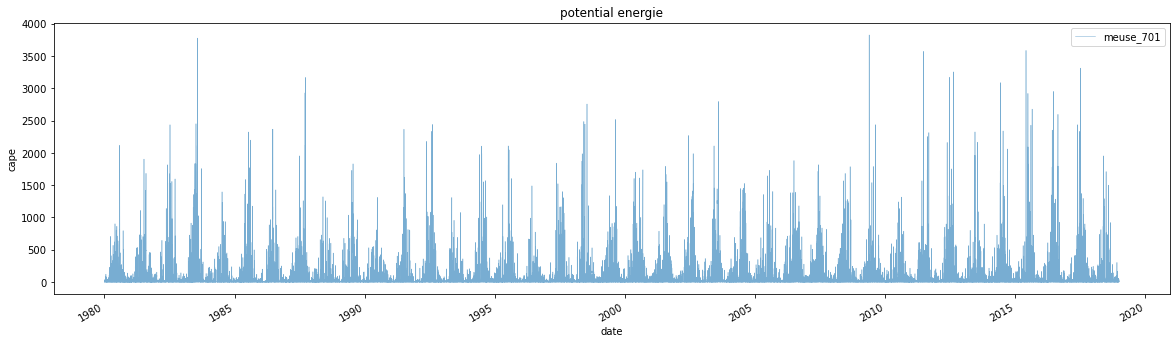

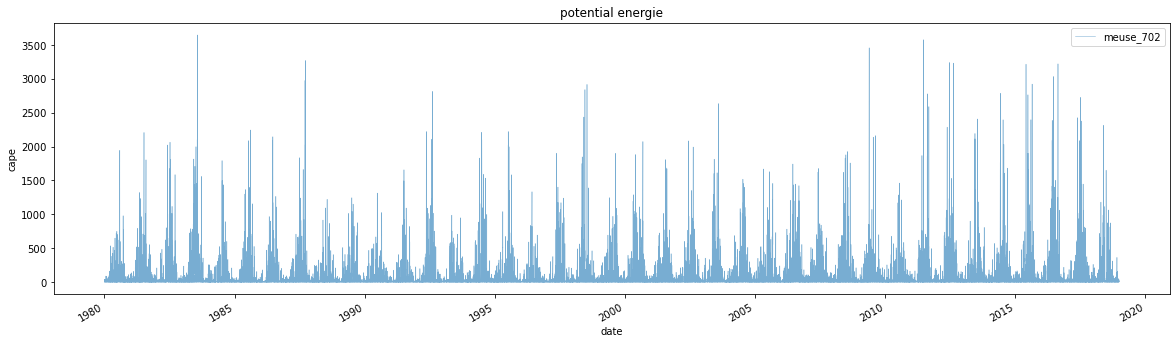

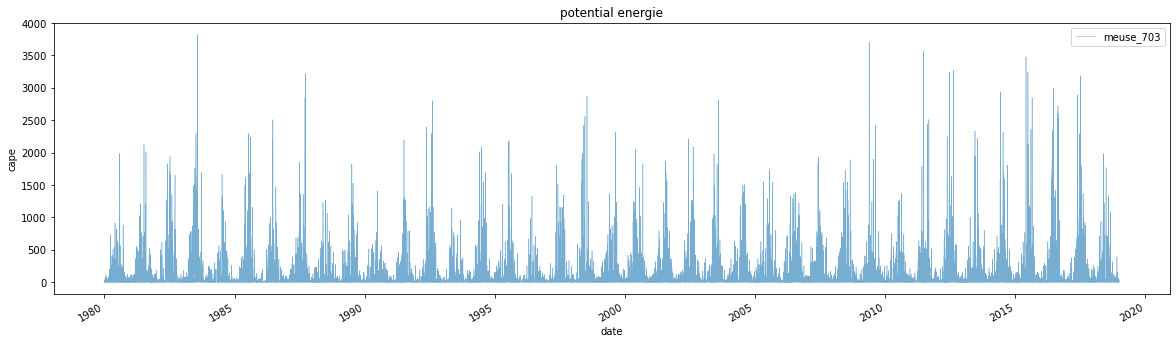

In [11]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')    
    fig = plt.subplots(figsize=(20, 5))
    ds.cape.plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()
    plt.title('potential energie')

#### Total precipitation:

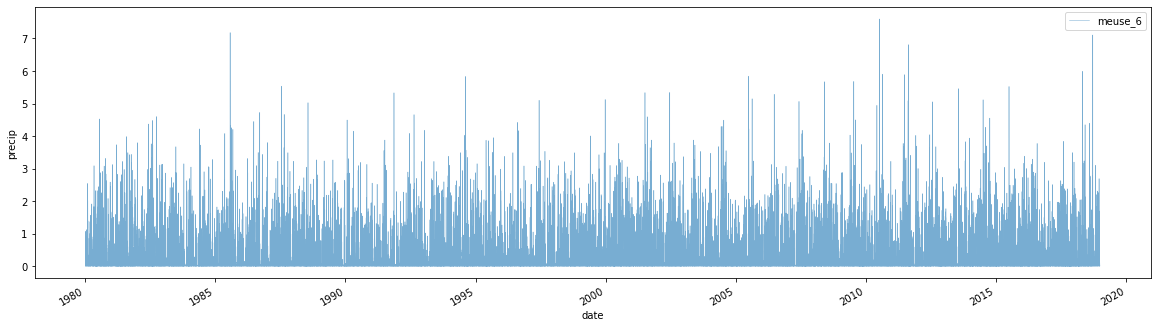

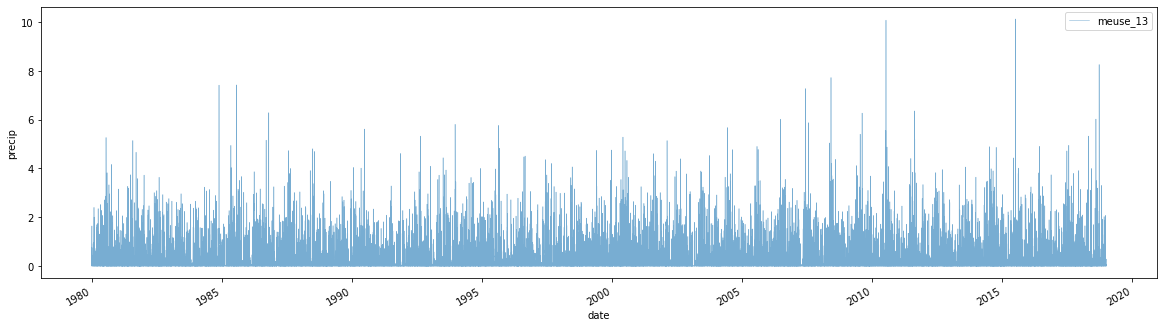

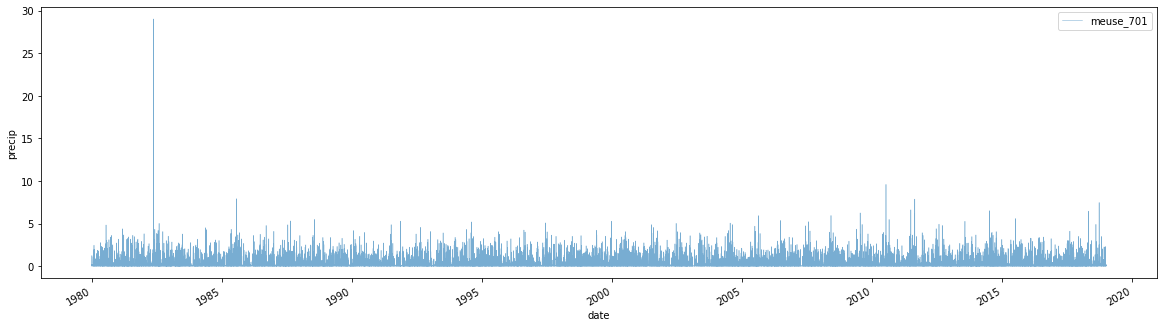

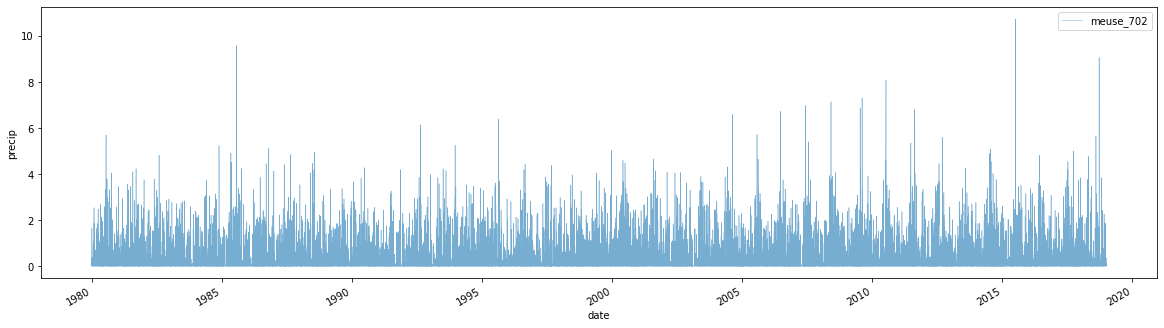

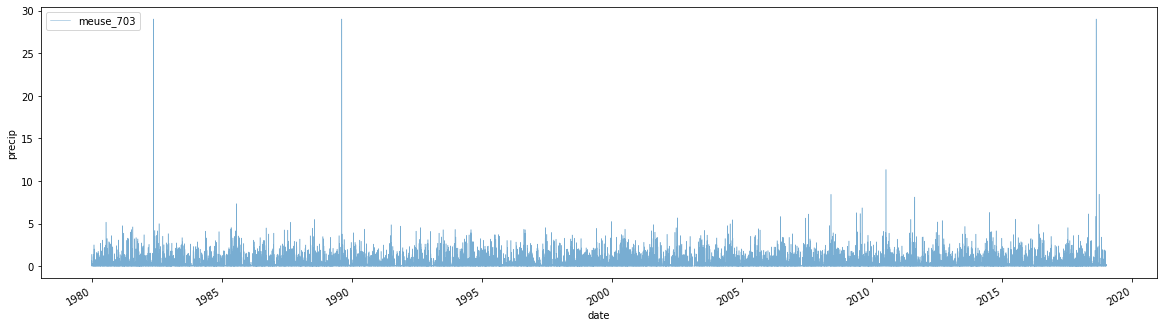

In [12]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')    
    fig = plt.subplots(figsize=(20, 5))
    ds['precip'].plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()

#### Convective precipitation:

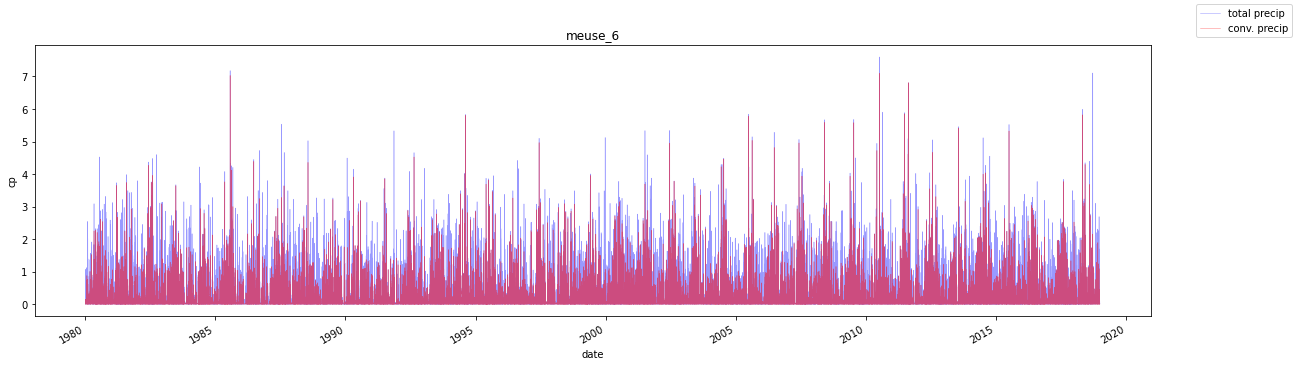

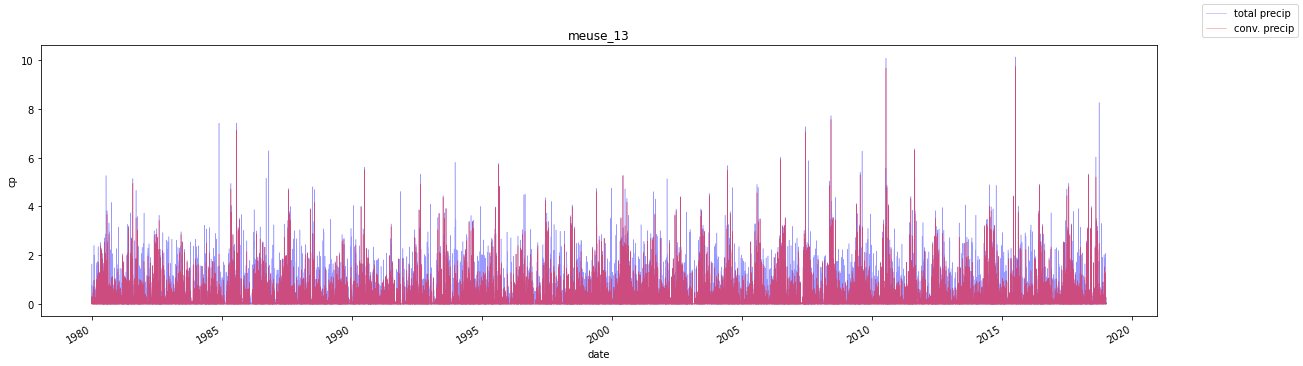

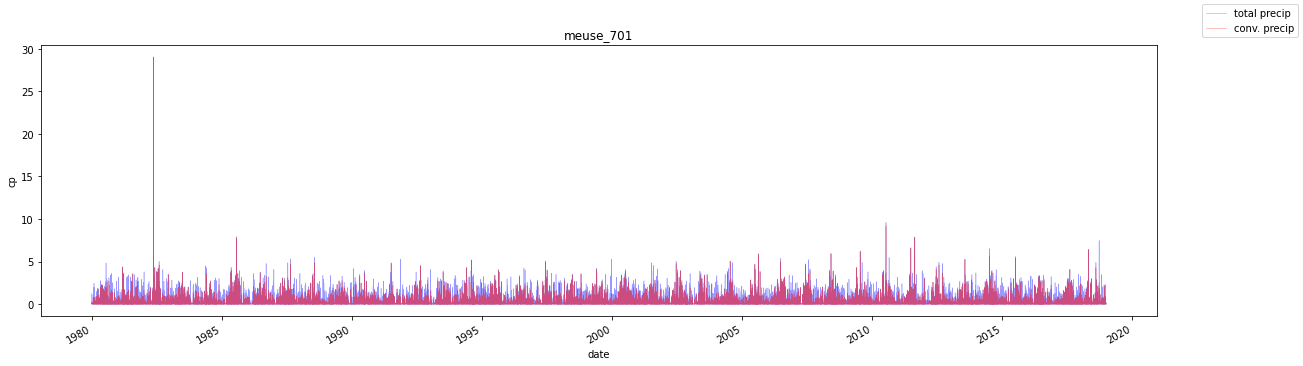

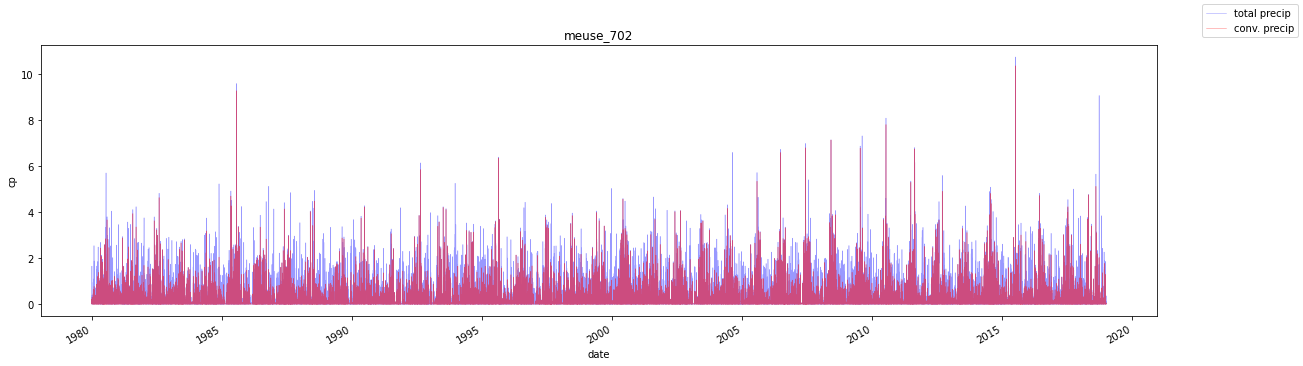

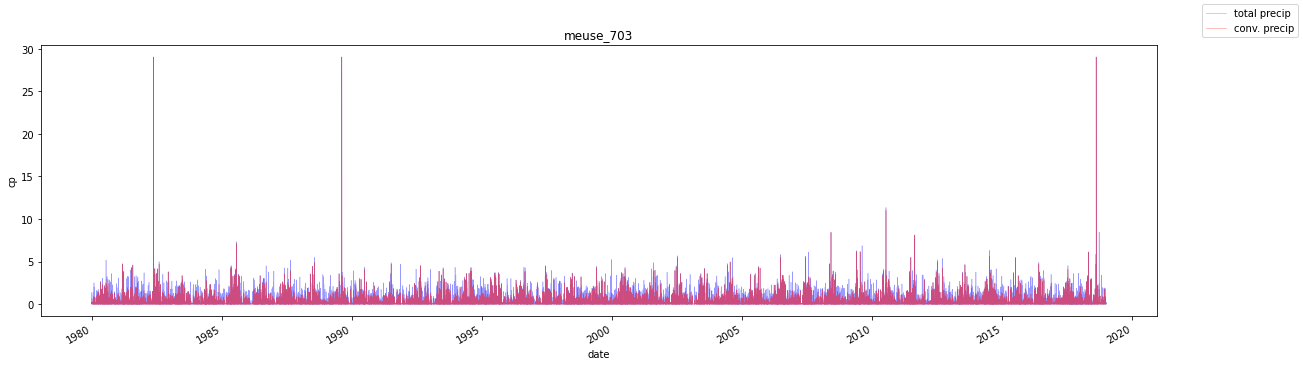

In [13]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig, ax2 = plt.subplots(figsize=(20, 5))
    ds.precip.plot(ax=ax2, lw=0.5, alpha=0.4, label='total precip', color='blue')
    ds['cp'].plot(ax=ax2, label='conv. precip', lw=0.5, alpha=0.5, color='red') #'red')
    fig.legend()
    plt.title(basin)

#### dew point temperature

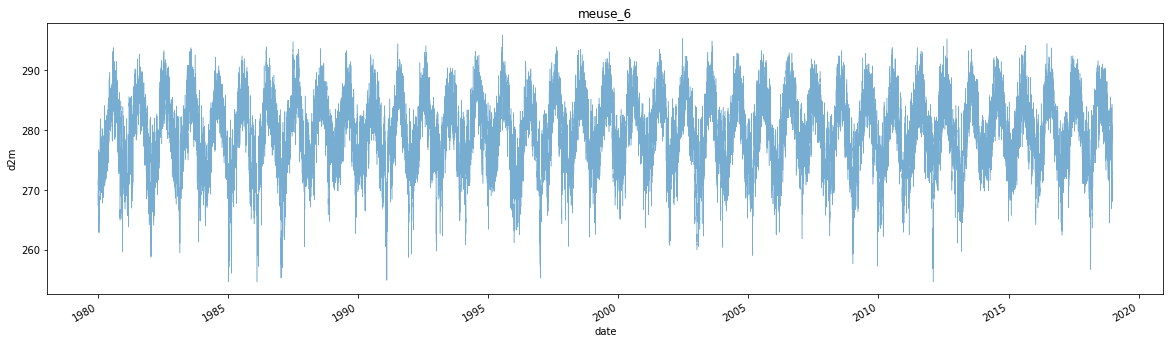

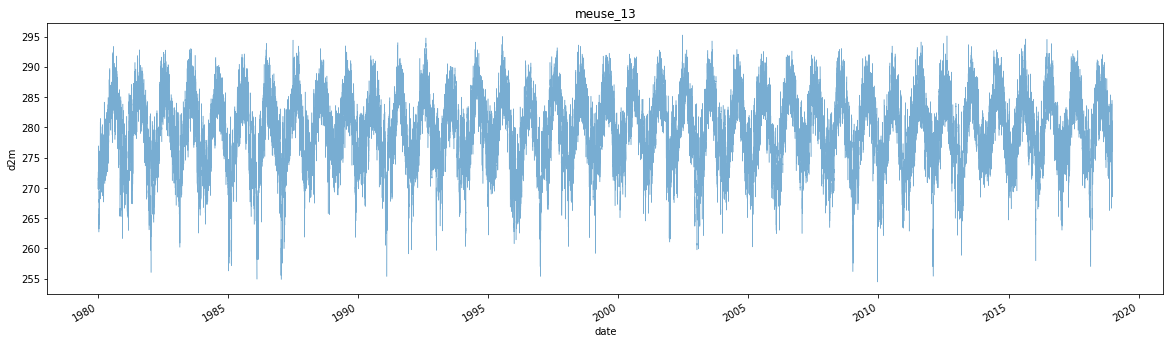

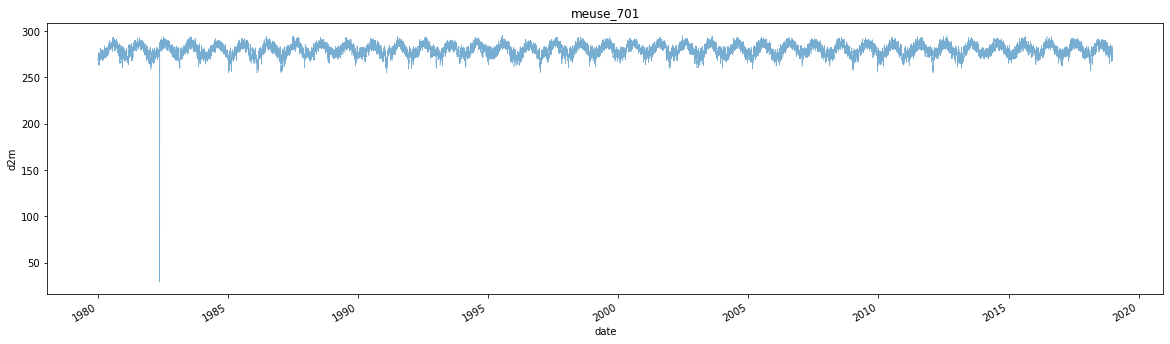

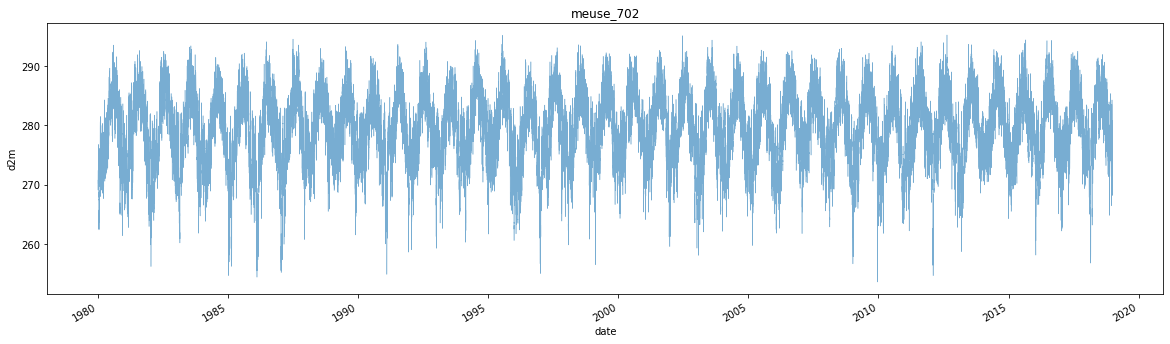

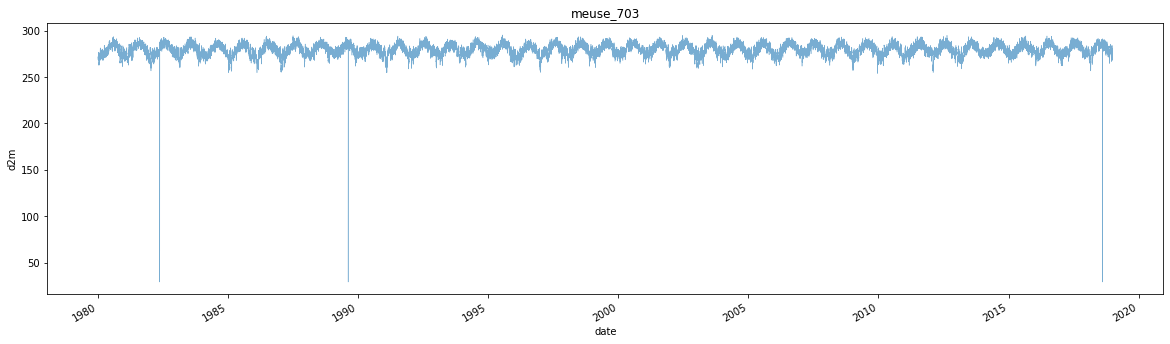

In [14]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig, ax1 = plt.subplots(figsize=(20, 5))
    ds.d2m.plot(label='era5', lw=0.5, alpha=0.6, ax=ax1)
    plt.title(basin)


#### long and shortwave radiation

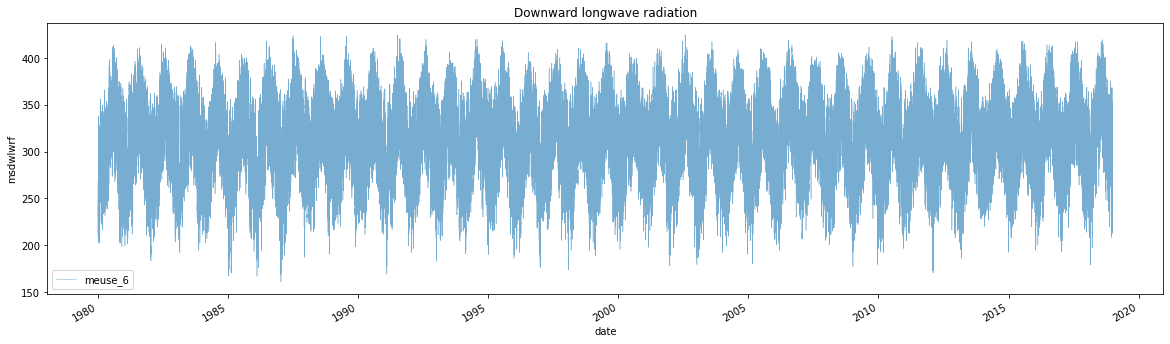

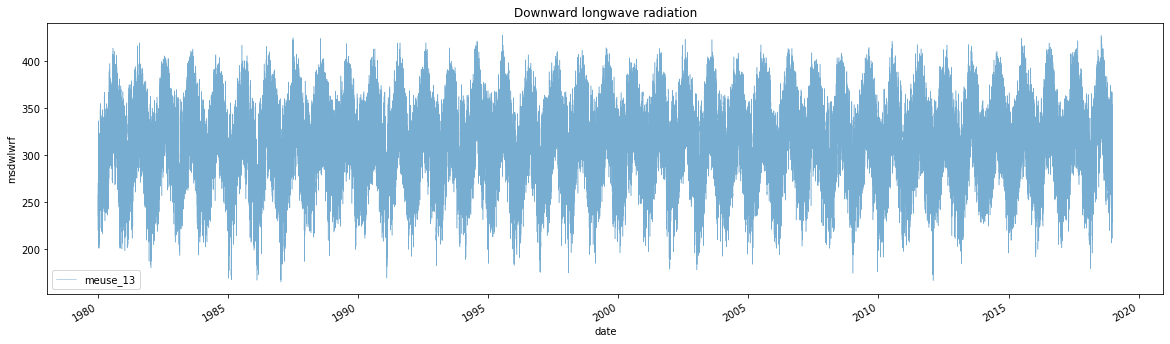

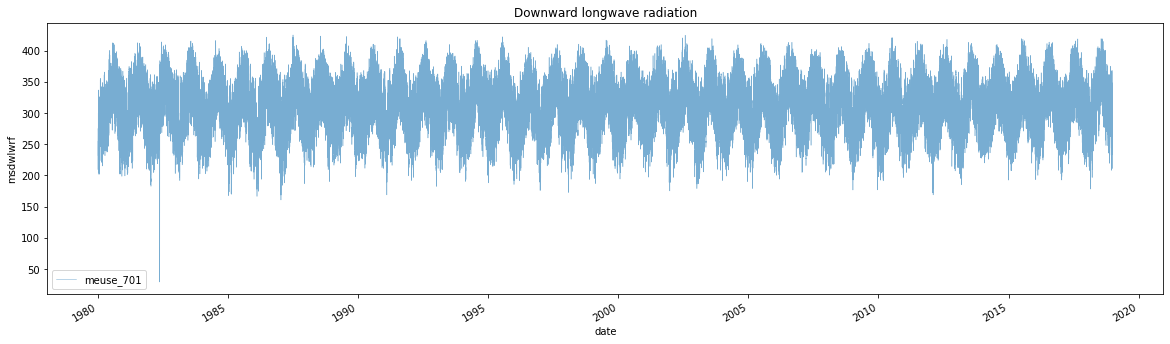

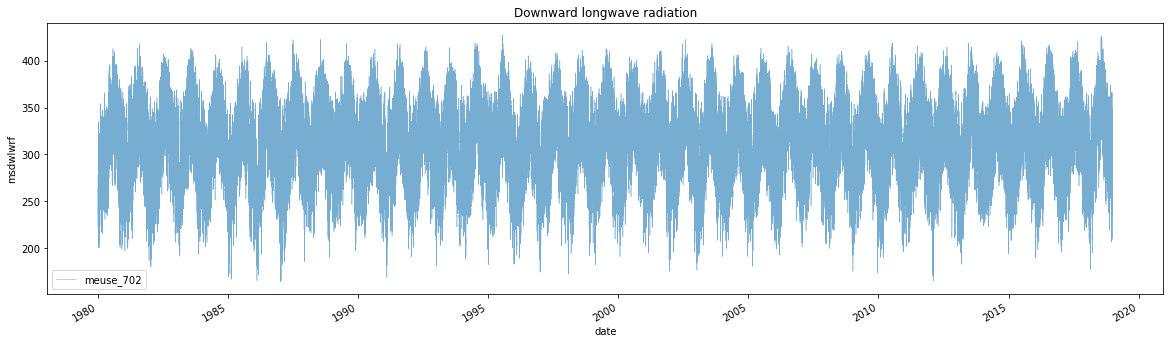

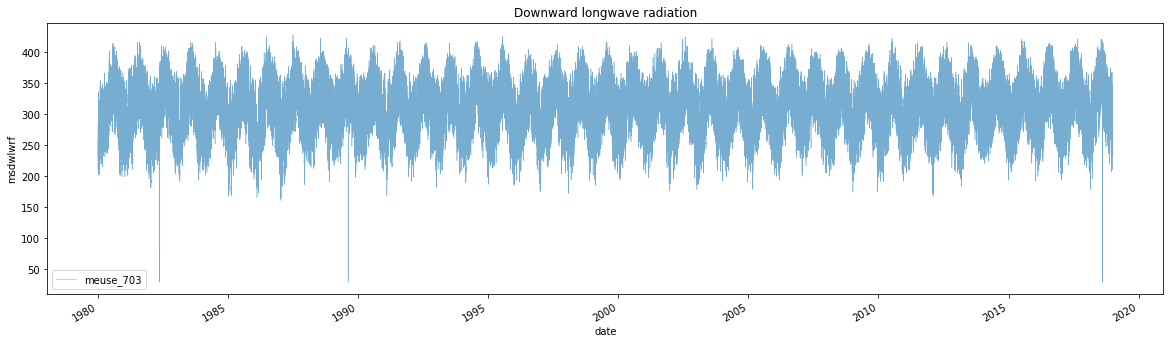

In [15]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig = plt.subplots(figsize=(20, 5))
    ds.msdwlwrf.plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()
    plt.title('Downward longwave radiation')

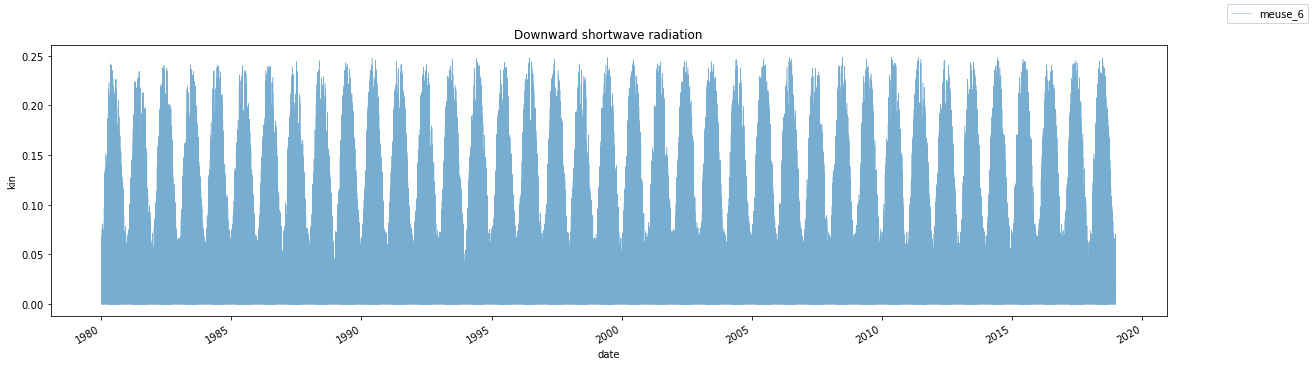

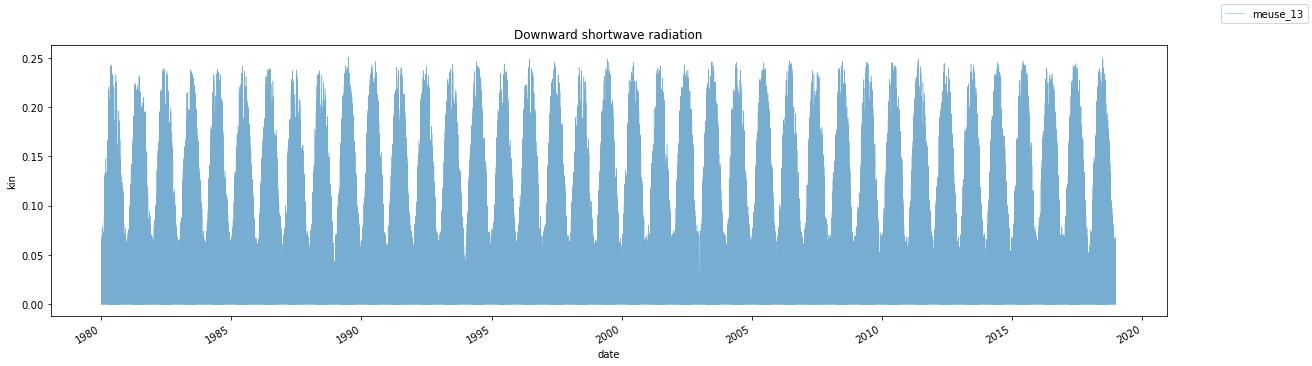

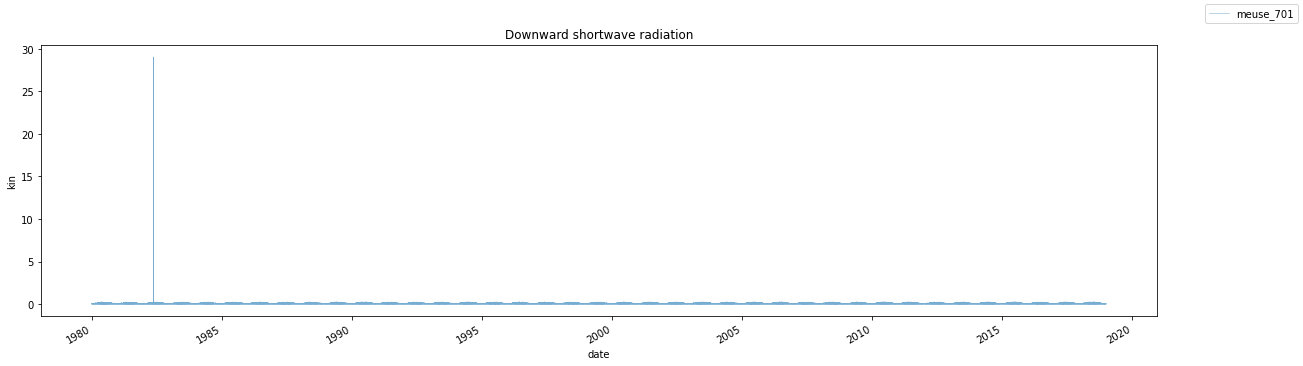

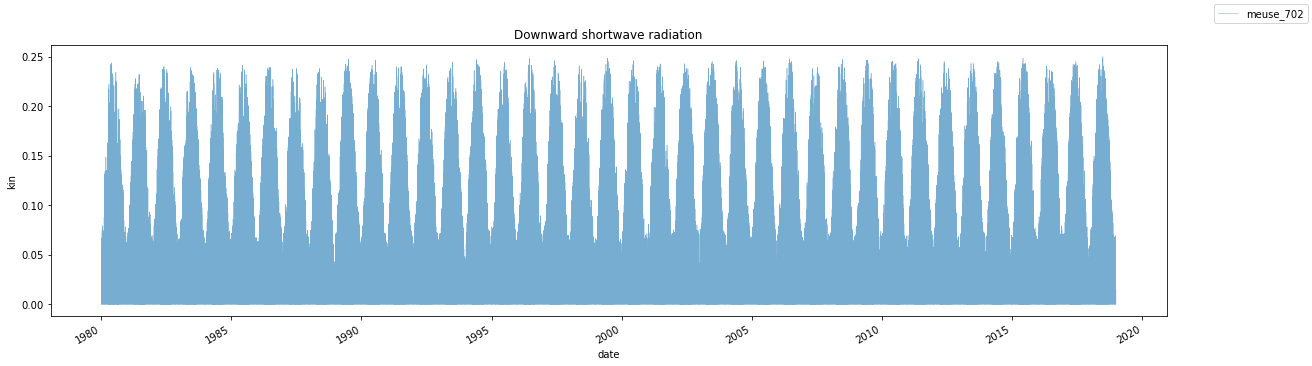

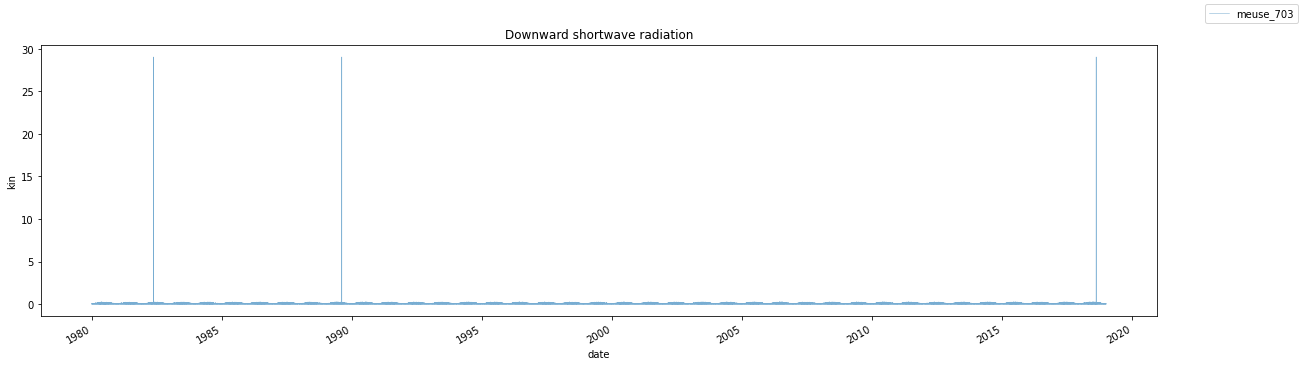

In [16]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig, ax1 = plt.subplots(figsize=(20, 5))
    ds.kin.plot(label=basin, lw=0.5, alpha=0.6, ax=ax1) # msdwswrf
    fig.legend()
    plt.title('Downward shortwave radiation')

#### potential evaporation

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


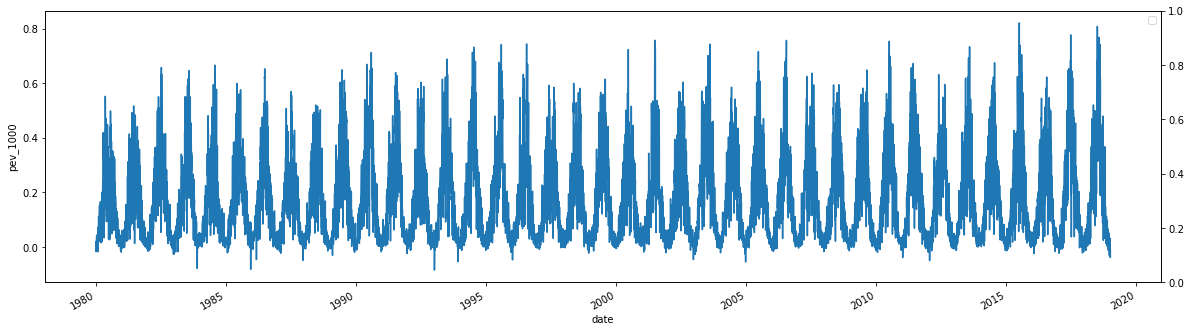

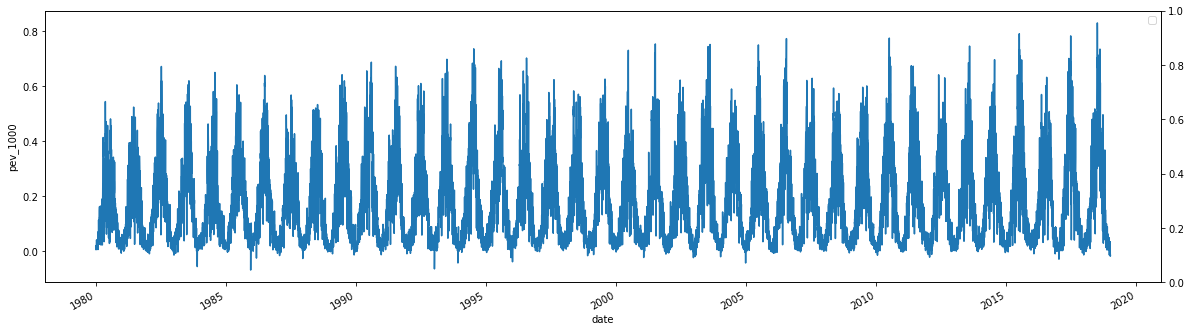

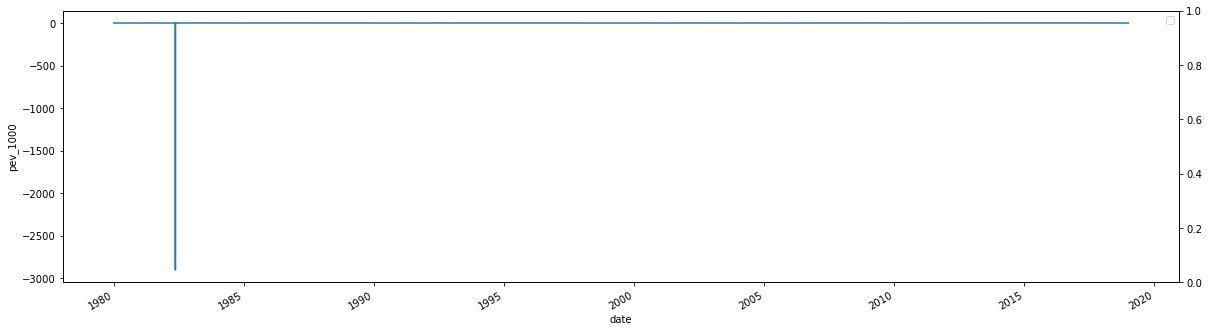

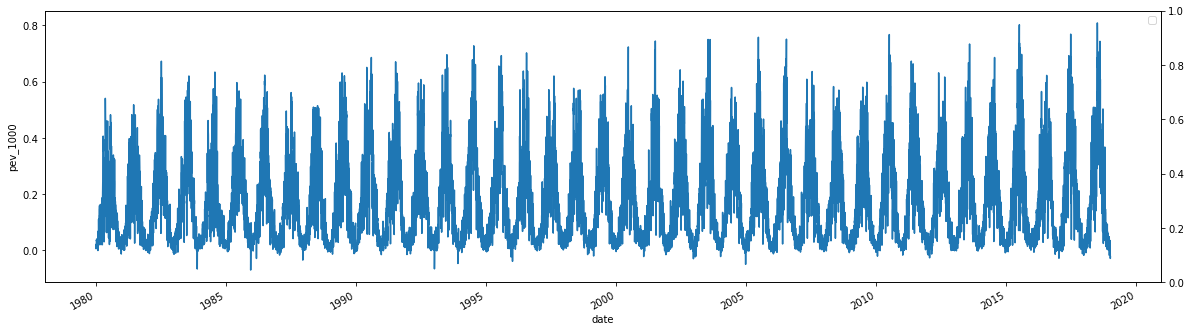

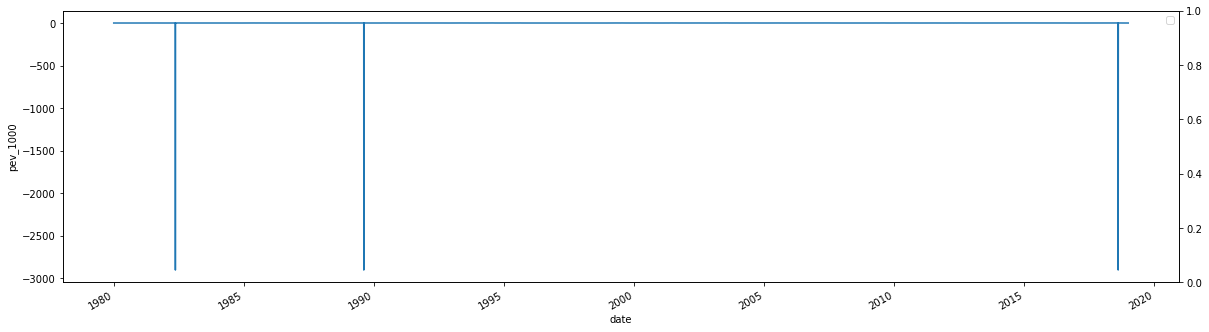

In [17]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    ds['pev_100'] = ds.pev * -100
    
    fig, ax1 = plt.subplots(figsize=(20, 5))

    ds['pev_100'].resample(date='1D').sum().plot(ax=ax1, label='era5_resample_day_100')
    plt.legend()


#### pressure

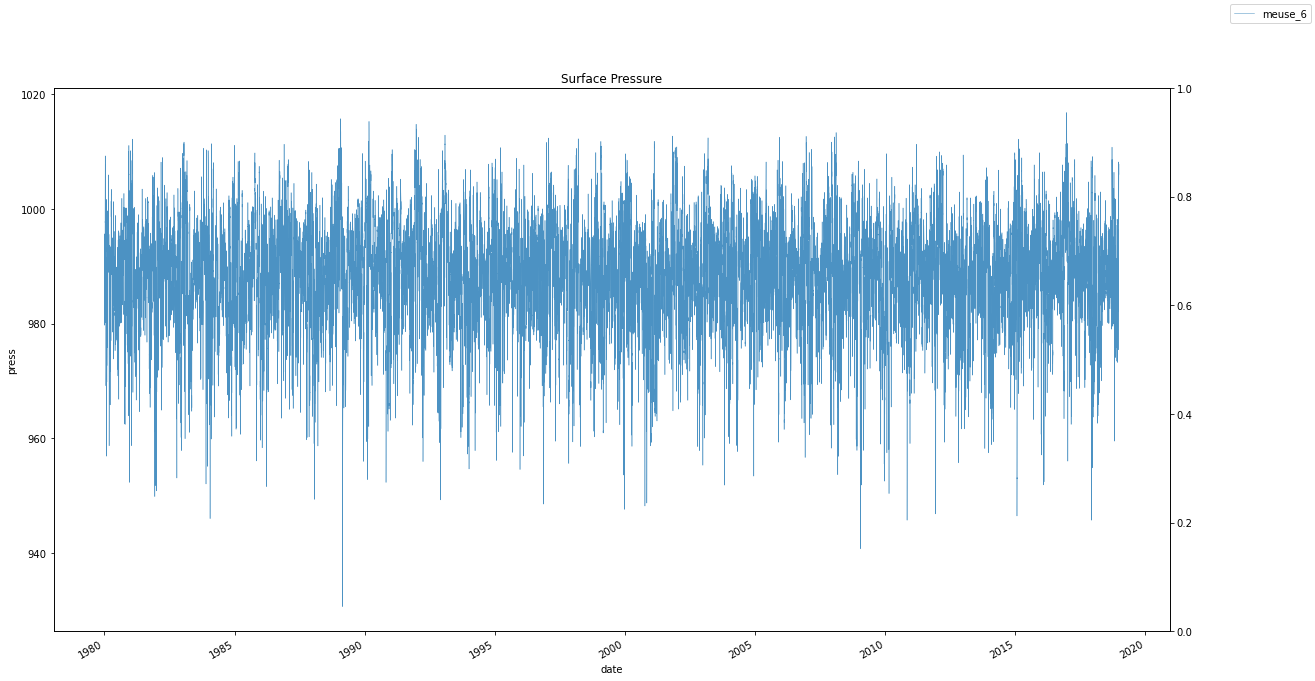

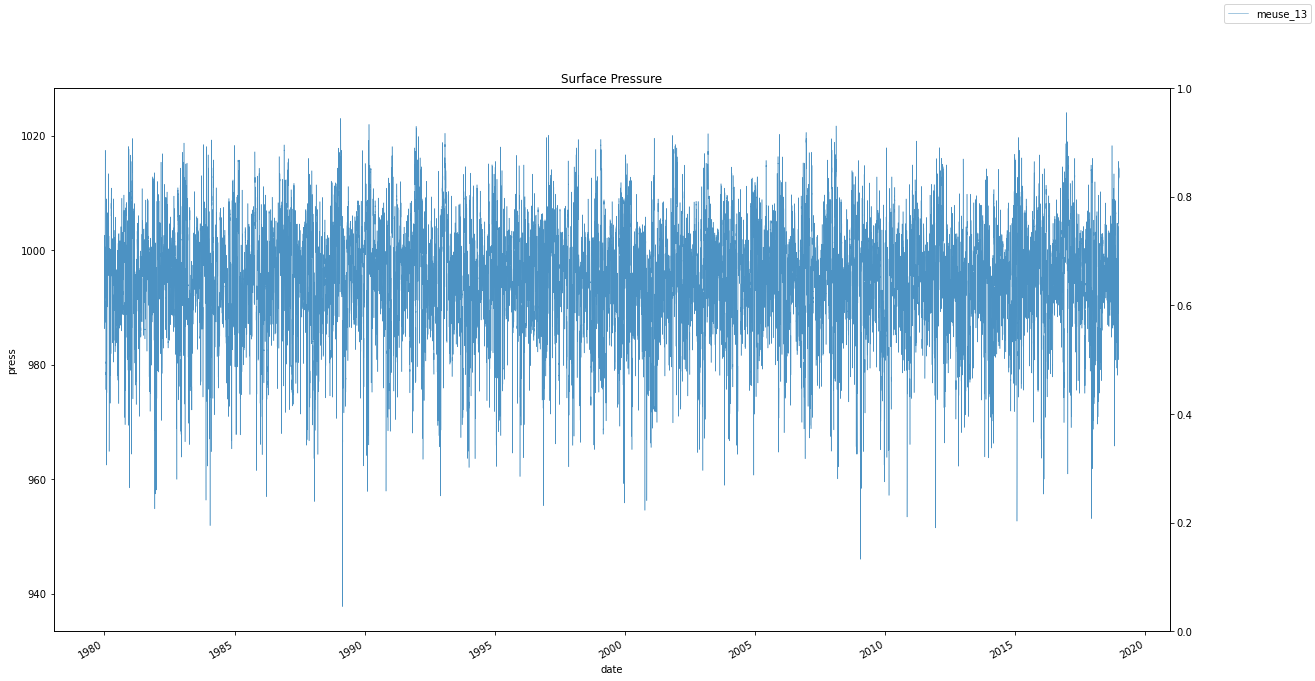

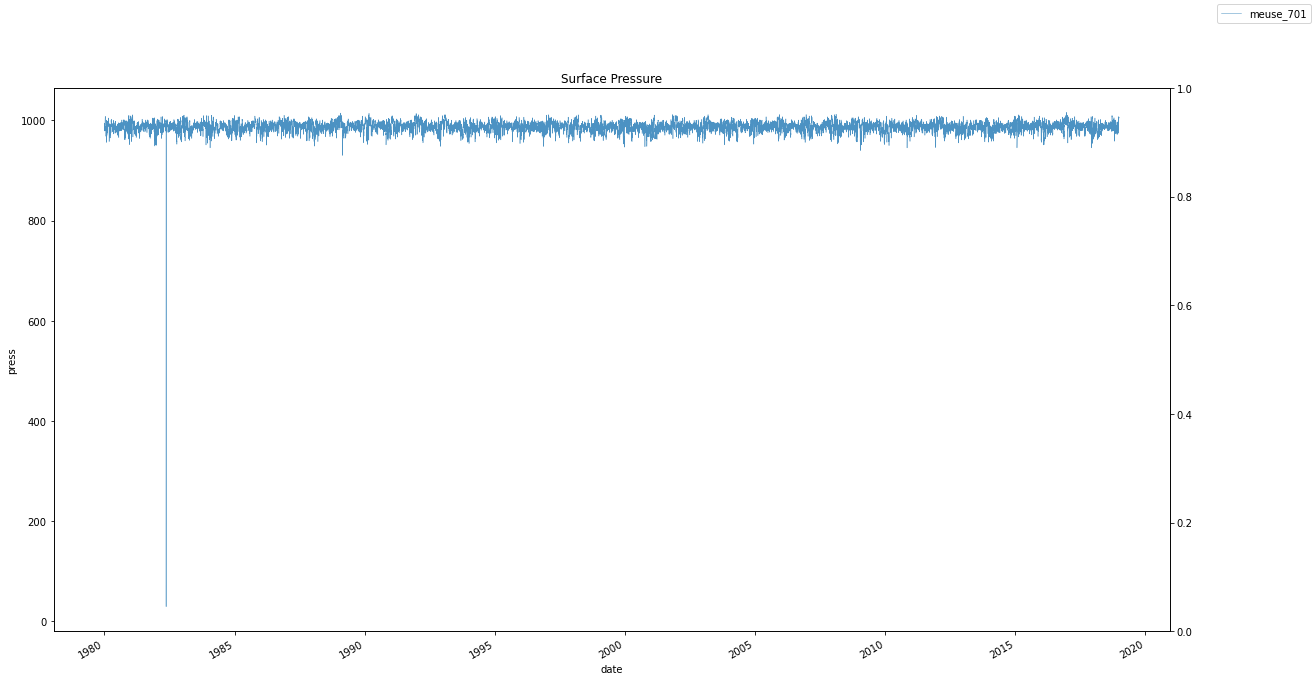

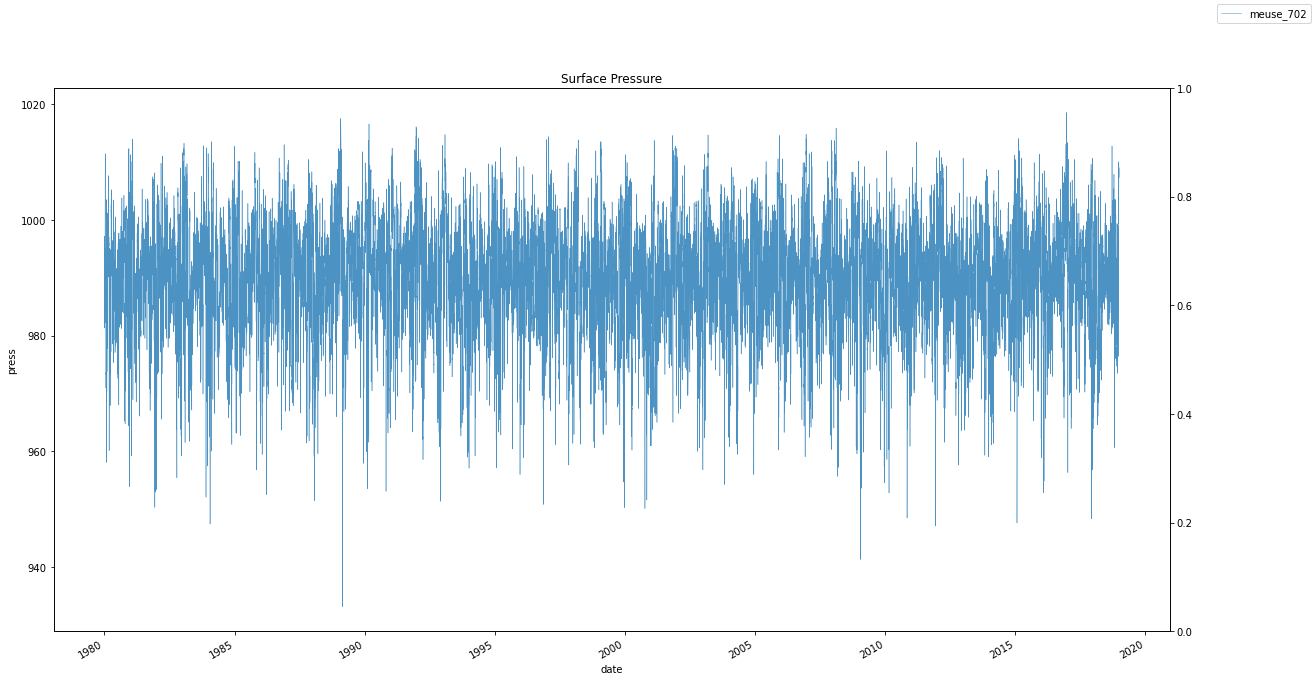

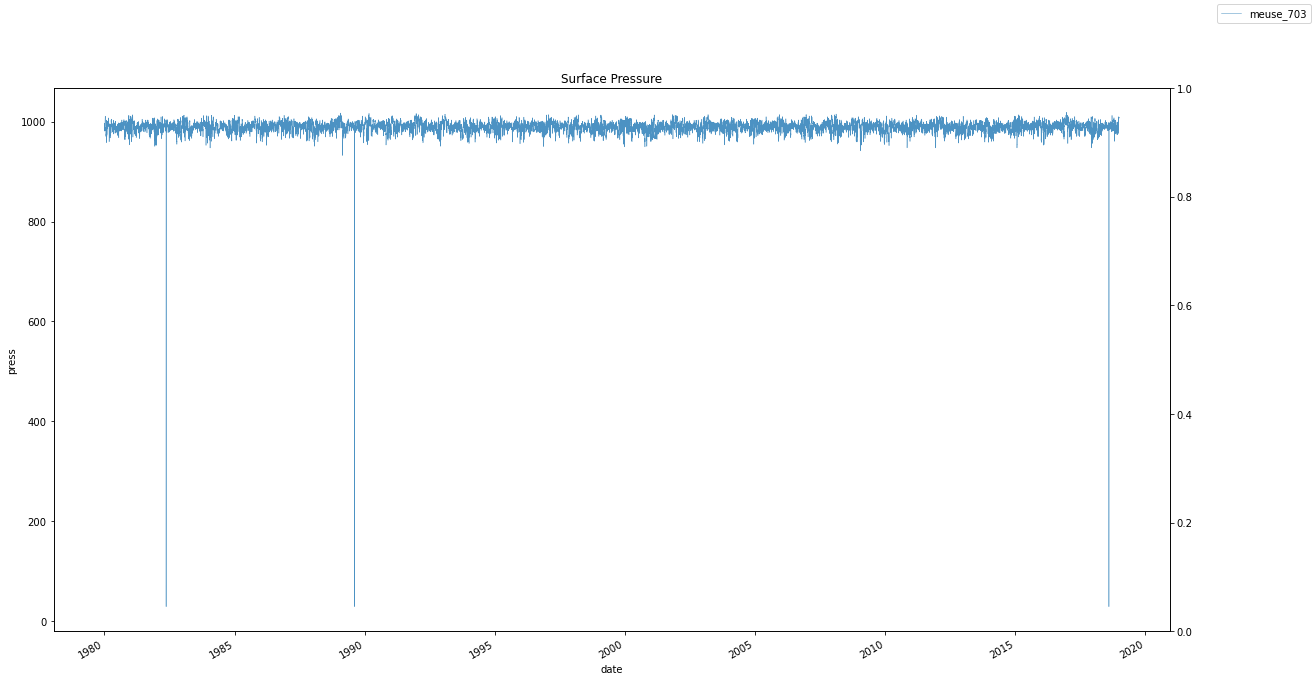

In [19]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()
    ds['press'].plot(label=basin, lw=0.5, alpha=0.8, ax=ax1)
    fig.legend()
    plt.title('Surface Pressure')

#### Temperature (2m):

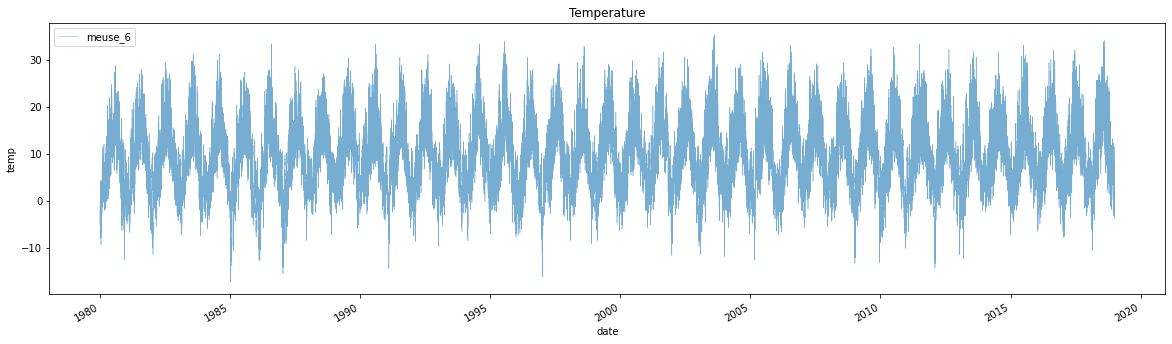

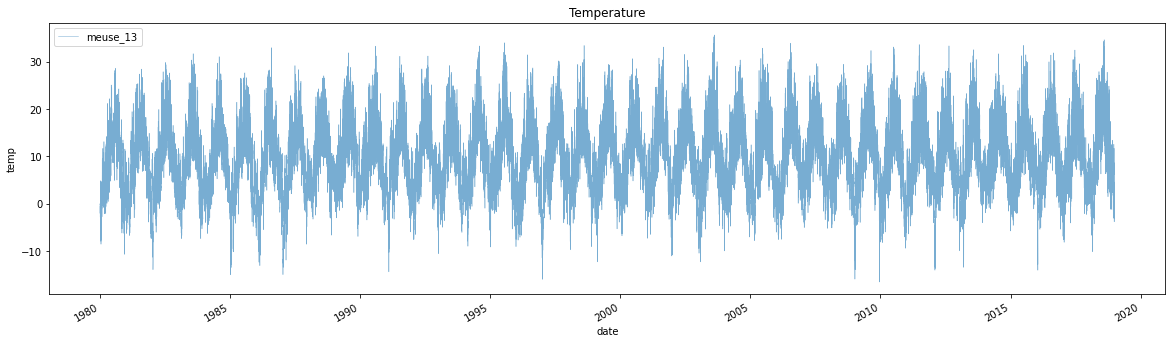

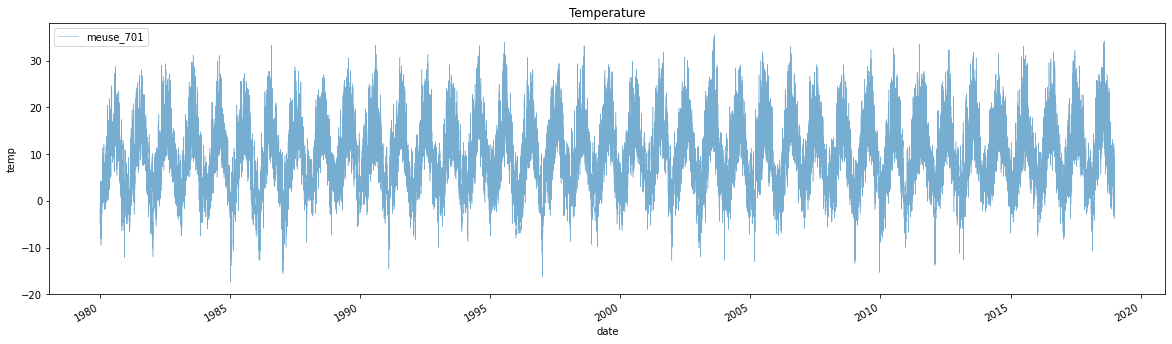

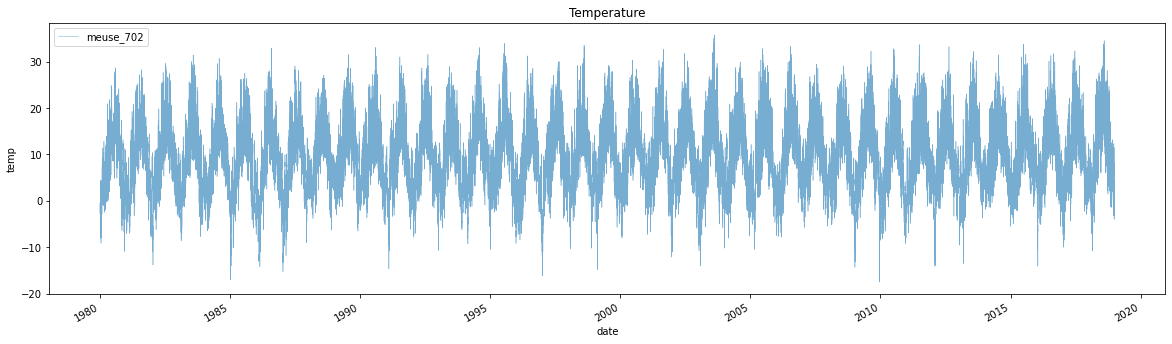

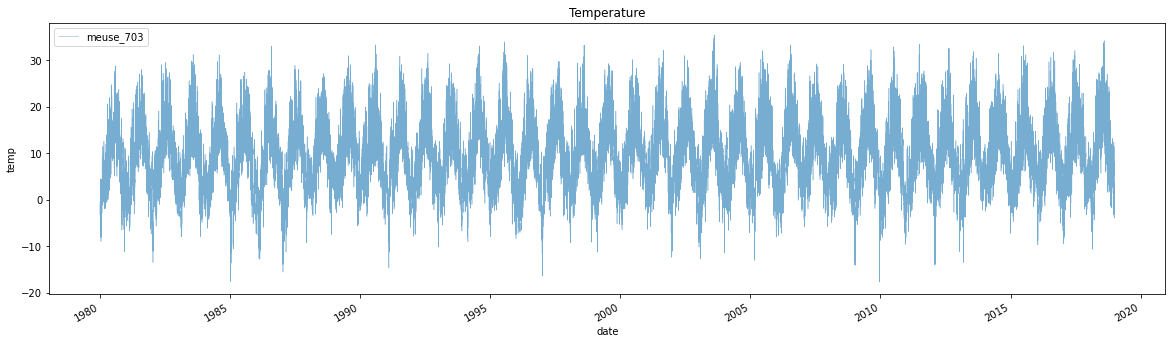

In [20]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig = plt.subplots(figsize=(20, 5))
    ds.temp.plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()
    plt.title('Temperature')

#### Wind u and v:

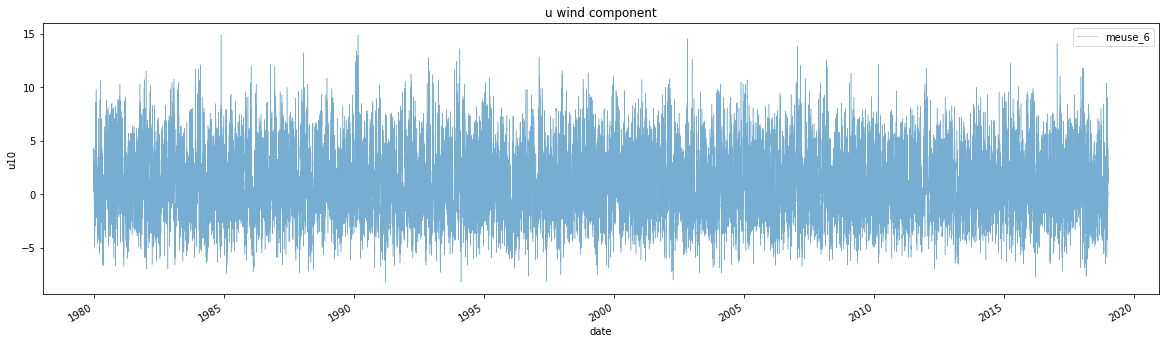

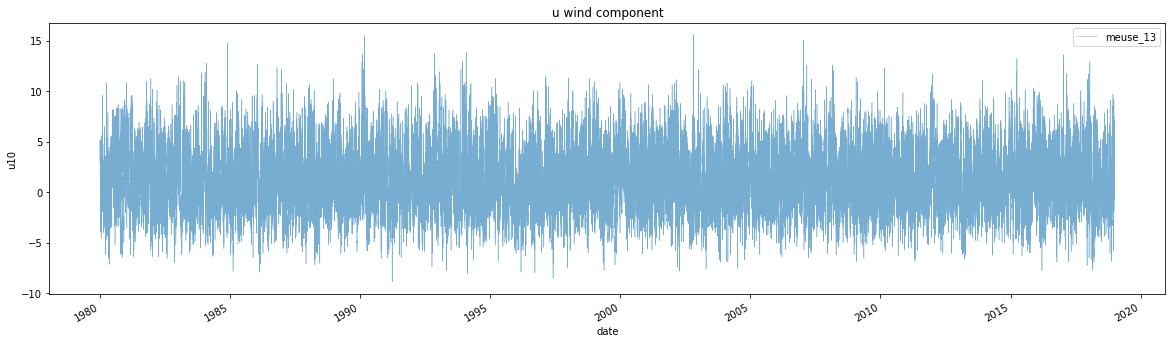

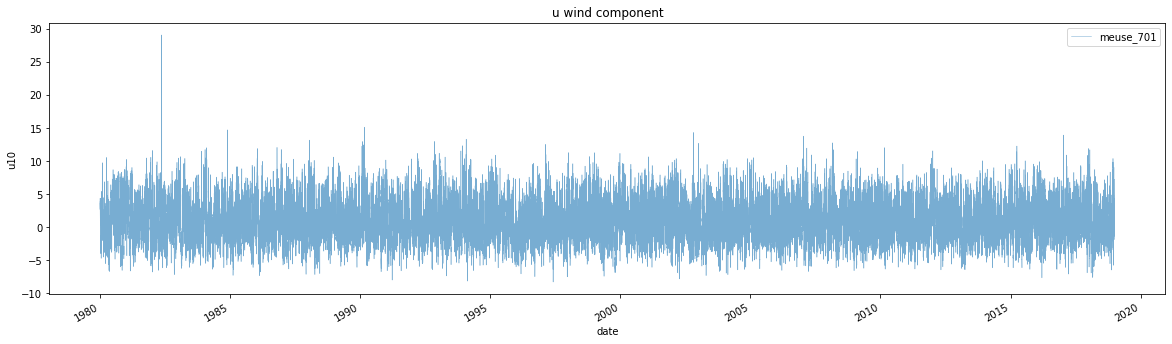

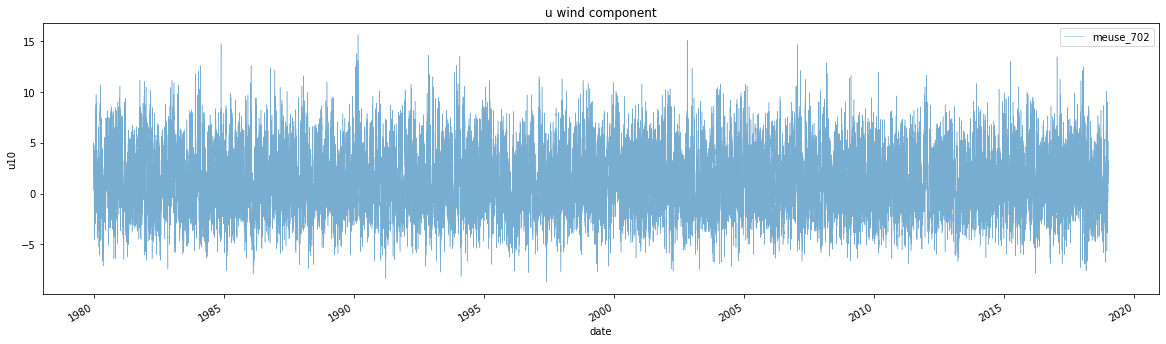

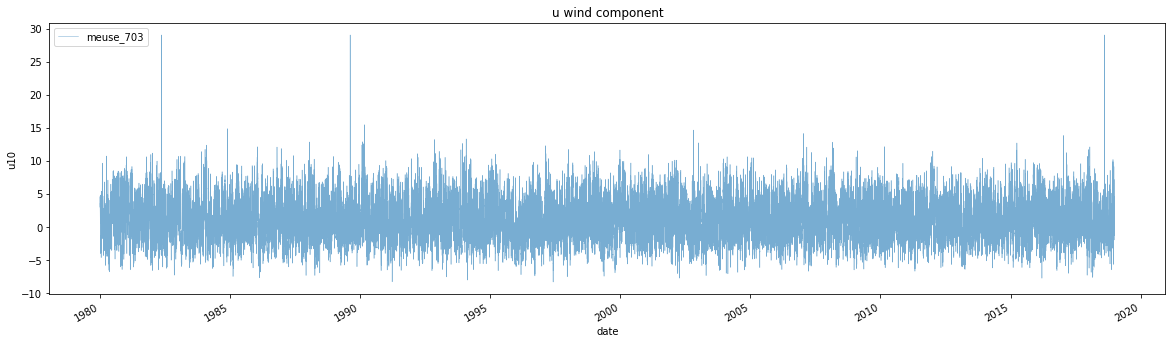

In [21]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig = plt.subplots(figsize=(20, 5))
    ds.u10.plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()
    plt.title('u wind component')

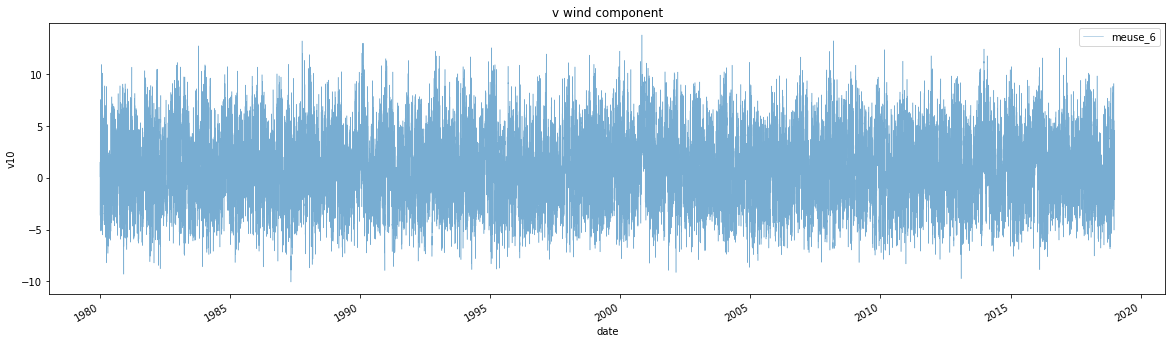

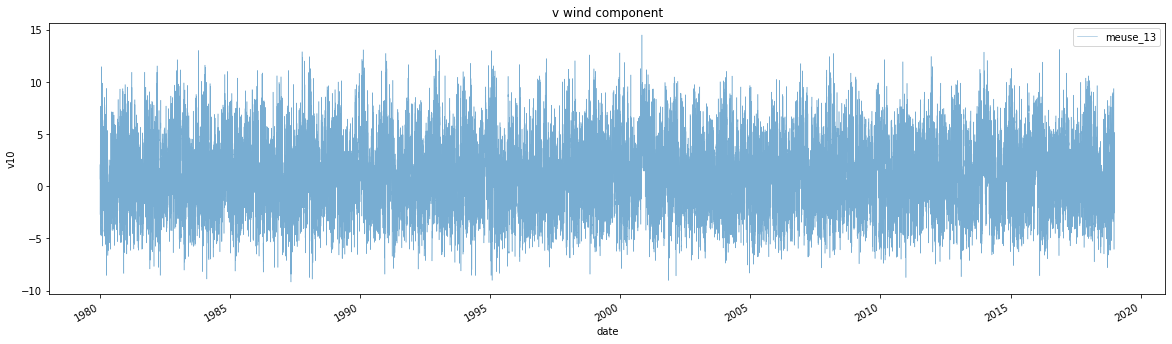

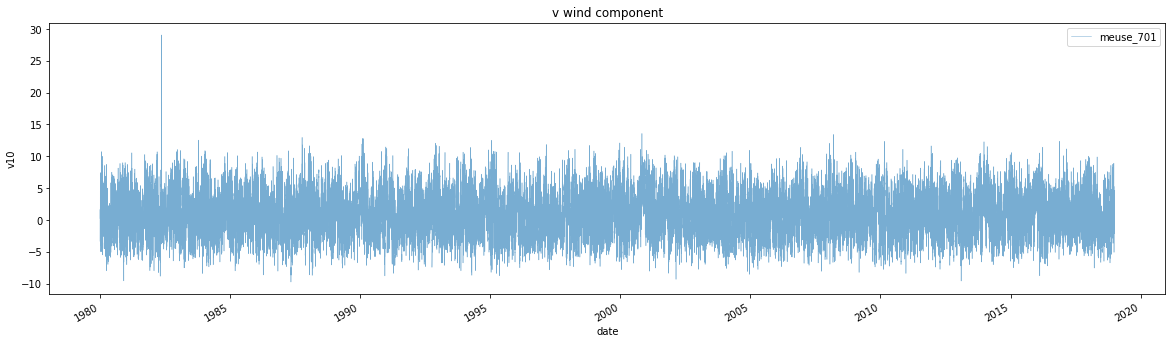

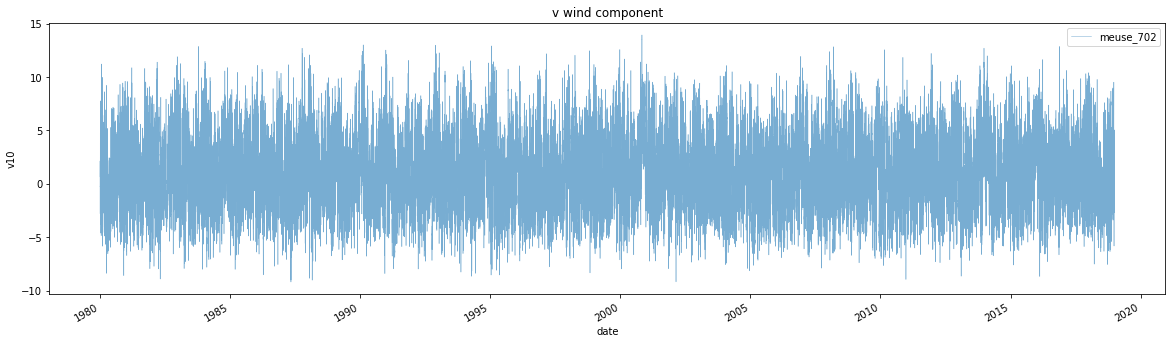

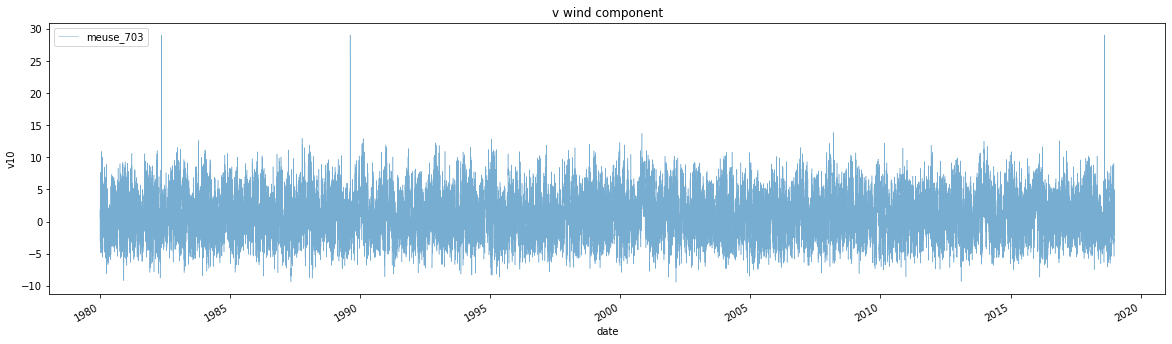

In [22]:
for basin in basins:
    ds = xr.open_dataset('data/europe/time_series/' + basin + '.nc')
    fig = plt.subplots(figsize=(20, 5))
    ds.v10.plot(label=basin, lw=0.5, alpha=0.6)
    plt.legend()
    plt.title('v wind component')

## Remove outliers

meuse_703


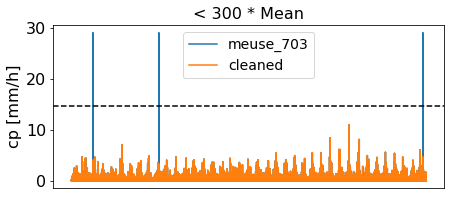

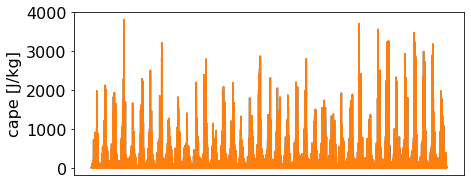

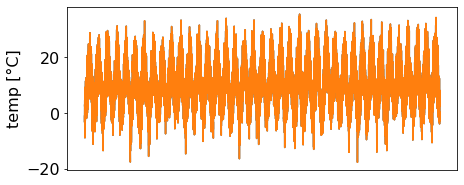

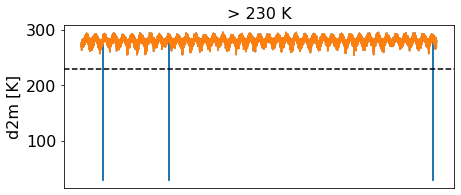

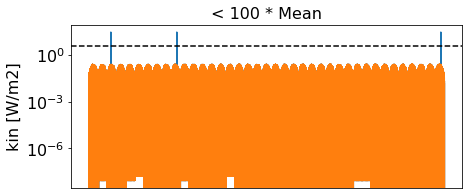

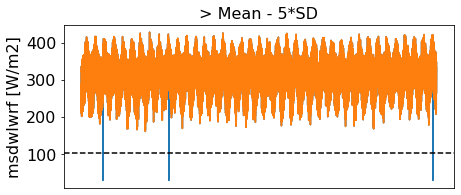

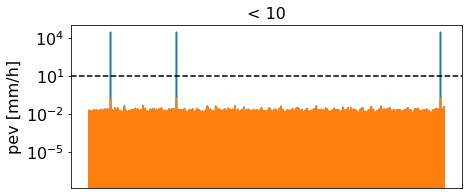

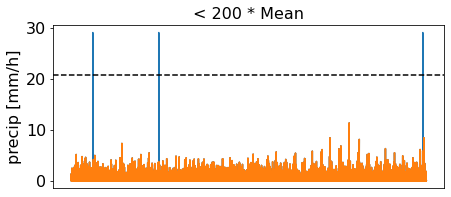

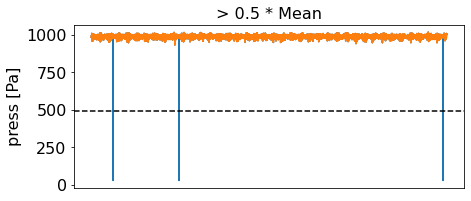

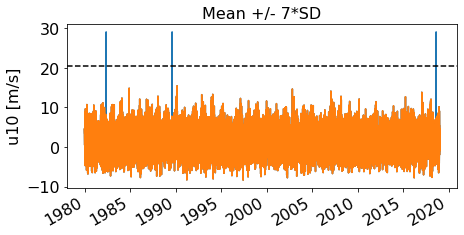

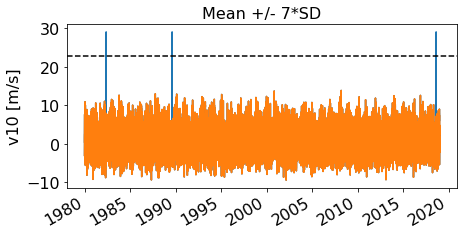

In [38]:
for basin in basins:
    if basin.endswith('703'): #  or basin.endswith('701')
        print(basin)
        ds = xr.open_dataset('E:/thesis_data/My_MTS-LSTM/data/europe/europe/time_series/' + basin + '.nc')    

#         # PET
#         fig, ax1 = plt.subplots(figsize=(7, 3))
#         ds.pet.plot(ax=ax1, label='raw', lw=1)
#         std = ds.pet.std()
#         mean = ds.pet.mean()
#         ds_n = ds.where((ds.pet >  mean-5*std) & (ds.pet < mean+5*std), other=mean)
#         ds_n.pet.plot(ax=ax1, label='cleaned', lw=1)
#         plt.axhline(mean-5*std, color='black', ls='--')
#         plt.axhline(mean+5*std, color='black', ls='--')
#         plt.ylim(27, 32)
#         plt.tick_params('y', labelsize=16)
#         plt.tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom=False,      # ticks along the bottom edge are off
#             top=False,         # ticks along the top edge are off
#             labelbottom=False)
#         plt.legend(fontsize=14)
#         plt.title('Mean +/- 5*SD', fontsize=16)
#         plt.xlabel('', fontsize=16)
#         plt.ylabel('PET', fontsize=16)

        # CP
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.cp.plot(ax=ax1, label=basin)
        mean = ds.cp.mean()
        ds_n = ds.where((ds.cp < mean*300), other=mean)
        ds_n.cp.plot(ax=ax1, label='cleaned')
        plt.axhline(mean*300, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.legend(fontsize=14)
        plt.title('< 300 * Mean', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('cp [mm/h]', fontsize=16)
        
        # Cape
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.cape.plot(ax=ax1, label=basin)
        mean = ds.cape.mean()
        ds_n = ds.where((ds.cape), other=mean)
        ds_n.cape.plot(ax=ax1, label='cleaned')
#         plt.axhline(15, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('cape [J/kg]', fontsize=16)
        
        # temp
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.temp.plot(ax=ax1, label=basin)
        mean = ds.temp.mean()
        ds_n = ds.where((ds.temp), other=mean)
        ds_n.temp.plot(ax=ax1, label='cleaned')
#         plt.axhline(230, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('temp [°C]', fontsize=16)
        
        # D2m
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.d2m.plot(ax=ax1, label=basin)
        mean = ds.d2m.mean()
        ds_n = ds.where((ds.d2m > 230), other=mean)
        ds_n.d2m.plot(ax=ax1, label='cleaned')
        plt.axhline(230, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('> 230 K', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('d2m [K]', fontsize=16)

        # kin
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.kin.plot(ax=ax1, label=basin)
        mean = ds.kin.mean()
        ds_n = ds.where((ds.kin < 100 * mean), other=mean)
        ds_n.kin.plot(ax=ax1, label='cleaned')
        plt.axhline(100*mean, color='black', ls='--')
        plt.yscale('log')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('< 100 * Mean', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('kin [W/m2]', fontsize=16)
        
        # msdwlwrf
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.msdwlwrf.plot(ax=ax1, label=basin)
        mean = ds.msdwlwrf.mean()
        std = ds.msdwlwrf.std()
        ds_n = ds.where((ds.msdwlwrf > mean - 5*std), other=mean)
        ds_n.msdwlwrf.plot(ax=ax1, label='cleaned')
        plt.axhline(mean-5*std, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('> Mean - 5*SD', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('msdwlwrf [W/m2]', fontsize=16)
        
        # pev
        fig, ax1 = plt.subplots(figsize=(7, 3))
        p = ds.pev * 1000
        p.plot(ax=ax1, label=basin)
        mean = p.mean() 
        ds_n = p.where((p < 10), other=mean) # ds.pev < 1
        ds_n.plot(ax=ax1, label='cleaned')
        plt.axhline(10, color='black', ls='--')
        plt.yscale('log')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('< 10', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('pev [mm/h]', fontsize=16)
        
        # precip
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.precip.plot(ax=ax1, label=basin)
        mean = ds.precip.mean()
        std = ds.precip.std()
        ds_n = ds.where((ds.precip < mean * 200), other=mean) # < 15
        ds_n.precip.plot(ax=ax1, label='cleaned')
        plt.axhline(mean * 200, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('< 200 * Mean', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('precip [mm/h]', fontsize=16)
        
        # press
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.press.plot(ax=ax1, label=basin)
        mean = ds.press.mean()
        std = ds.press.std()
        ds_n = ds.where((ds.press > 0.5 * mean), other=mean) # > 150
        ds_n.press.plot(ax=ax1, label='cleaned')
        plt.axhline(mean*0.5, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.title('> 0.5 * Mean', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('press [Pa]', fontsize=16)
        
        
        # u10
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.u10.plot(ax=ax1, label=basin)
        mean = ds.u10.mean()
        std = ds.u10.std()
        ds_n = ds.where((ds.u10 < mean + 7 * std), other=mean) # < 20
#         ds_n = ds.where((ds.u10 < 20), other=mean)
        ds_n.u10.plot(ax=ax1, label='cleaned')
        plt.axhline(mean+7*std, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both', labelsize=16)
        plt.title('Mean +/- 7*SD', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('u10 [m/s]', fontsize=16)
        
        
        # v10
        fig, ax1 = plt.subplots(figsize=(7, 3))
        ds.v10.plot(ax=ax1, label=basin)
        mean = ds.v10.mean()
        std = ds.v10.std()
        ds_n = ds.where((ds.v10 < mean + 7 * std), other=mean) # < 20
        ds_n.v10.plot(ax=ax1, label='cleaned')
        plt.axhline(mean+7*std, color='black', ls='--')
        plt.tick_params('y', labelsize=16)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both', labelsize=16)
        plt.title('Mean +/- 7*SD', fontsize=16)
        plt.xlabel('', fontsize=16)
        plt.ylabel('v10 [m/s]', fontsize=16)
        
#         ds.to_netcdf('data/europe/time_series/' + basin + '_cleaned.nc')